# Computing features to train a MLP
This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to computing the histogram of gradients from the images in the `mnist` dataset (LeCun et al. 1998)

## Loading the packages

In [1]:
%pip install tensorflow --upgrade
%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from skimage.feature import hog
from skimage import data, color, exposure

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import utils as np_utils
from sklearn import metrics as me

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


### An example of how to compute the histogram of gradients
Let's compute the HOG for one image in the test dataset

In [3]:
n_orientations = 8
pix_p_cell = 4
hog_size = int(height * width * n_orientations / (pix_p_cell * pix_p_cell))

In [4]:
fd, hog_image = hog(X_test[0,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

Show the image and the corresponding gradients

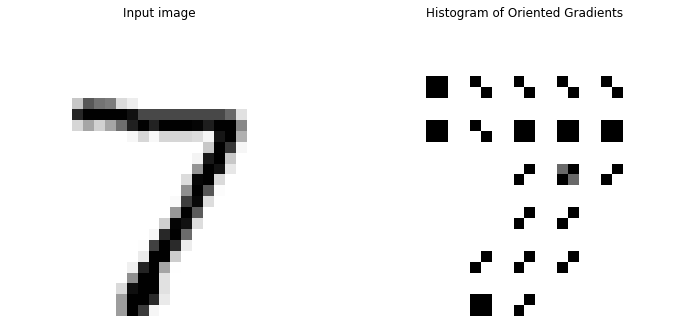

In [5]:
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(X_test[0,:,:,0], cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax1.set_title('Input image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=pl.get_cmap('Greys'), interpolation='nearest')
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box')

Compute the HOGs for the train and test datasets

> Indented block



In [6]:
X_train_hog = np.zeros((X_train.shape[0], hog_size))
X_test_hog = np.zeros((X_test.shape[0], hog_size))

for i in np.arange(X_train_hog.shape[0]):
    X_train_hog[i,:] = hog(X_train[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_train done')

for i in np.arange(X_test_hog.shape[0]):
    X_test_hog[i,:] = hog(X_test[i,:,:,0], orientations=n_orientations, pixels_per_cell=(pix_p_cell, pix_p_cell), cells_per_block=(1, 1), visualize=False)
print('X_test done')

X_train done
X_test done


Create the MLP

In [7]:
model = Sequential()
model.add(Dense(2000, input_shape=(hog_size,), activation='relu'))
model.add(Dense(2000, input_shape=(hog_size,), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2000)              786000    
                                                                 
 dense_1 (Dense)             (None, 2000)              4002000   
                                                                 
 dense_2 (Dense)             (None, 10)                20010     
                                                                 
Total params: 4,808,010
Trainable params: 4,808,010
Non-trainable params: 0
_________________________________________________________________


Define some constants and train the MLP

In [8]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])
history = model.fit(X_train_hog, Y_train,
                    batch_size=batch_size, epochs=n_epoch,
                    verbose=1, validation_data=(X_test_hog, Y_test))

Epoch 1/10
469/469 [==============================] - 19s 39ms/step - loss: 0.1458 - accuracy: 0.9532 - val_loss: 0.0767 - val_accuracy: 0.9771
Epoch 2/10
469/469 [==============================] - 17s 37ms/step - loss: 0.0576 - accuracy: 0.9825 - val_loss: 0.1175 - val_accuracy: 0.9721
Epoch 3/10
469/469 [==============================] - 17s 37ms/step - loss: 0.0374 - accuracy: 0.9887 - val_loss: 0.0878 - val_accuracy: 0.9785
Epoch 4/10
469/469 [==============================] - 17s 37ms/step - loss: 0.0287 - accuracy: 0.9920 - val_loss: 0.0845 - val_accuracy: 0.9827
Epoch 5/10
469/469 [==============================] - 18s 38ms/step - loss: 0.0202 - accuracy: 0.9944 - val_loss: 0.1523 - val_accuracy: 0.9748
Epoch 6/10
469/469 [==============================] - 18s 38ms/step - loss: 0.0184 - accuracy: 0.9953 - val_loss: 0.1174 - val_accuracy: 0.9842
Epoch 7/10
469/469 [==============================] - 19s 41ms/step - loss: 0.0140 - accuracy: 0.9967 - val_loss: 0.1424 - val_accuracy:

Show the performance of the model

Test score: 0.19067303836345673
Test accuracy: 0.9818999767303467


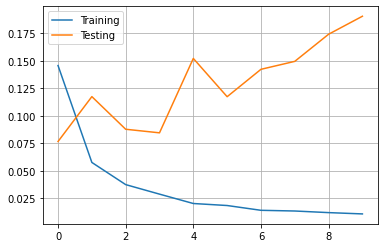

In [9]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test_hog, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [10]:
#pred = model.predict_classes(X_test_hog)
predict_x=model.predict(X_test_hog) 
pred=np.argmax(predict_x,axis=1)
me.confusion_matrix(y_test, pred)

array([[ 976,    0,    0,    0,    0,    1,    2,    1,    0,    0],
       [   5, 1115,    5,    2,    2,    2,    2,    0,    2,    0],
       [   2,    1, 1022,    0,    2,    0,    0,    3,    2,    0],
       [   0,    0,    3,  988,    0,   11,    0,    3,    5,    0],
       [   1,    0,    1,    1,  974,    0,    0,    0,    2,    3],
       [   1,    0,    0,    6,    0,  882,    3,    0,    0,    0],
       [   7,    2,    1,    0,    5,    2,  940,    0,    1,    0],
       [   0,    4,    7,    3,    2,    0,    0, 1007,    1,    4],
       [   7,    0,    2,    4,    1,    0,    0,    3,  957,    0],
       [   2,    2,    2,   11,    9,    5,    0,   10,   10,  958]],
      dtype=int64)

Note: you may need to restart the kernel to use updated packages.


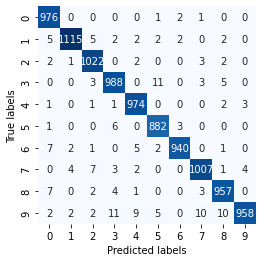

In [11]:
%pip install seaborn --upgrade
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    unique_labels = np.unique(y_true)
    cm = me.confusion_matrix(y_true, y_pred)
    
    sns.heatmap(
        cm, annot=True, fmt='g',
        xticklabels=unique_labels, yticklabels=unique_labels,
        square=True, cbar=False,
        cmap="Blues"
    )
    pl.xlabel("Predicted labels")
    pl.ylabel("True labels")

    pl.show()

plot_confusion_matrix(y_test, pred)